# Try This Exercise

Please find in the Canvas a file called "spec4000_corrected_weights".  This is a sample of spectra compiled by Ivezic to illustrate PCA.  The data does not come with errors, so I dummied up some weights.  Some of the spectra have fluxes less than zero, and the weights in those bins are set to zero.

The file is big, so you'll want to upload it into your "Temporary" directory on SciServer.  

Let's look at the form of the included data:

In [1]:
import pickle

with open("/home/idies/workspace/Temporary/bbonine/scratch/spec4000_corrected_weights", 'rb') as f:
    cv = pickle.load(f, encoding="latin1") 

flux=cv[0]
weights=cv[1]
wavelengths=cv[2]
labels=cv[3]
index=cv[4]

In [3]:
print (flux.shape)
print (weights.shape)
print (wavelengths.shape)
print (labels)
print (index.shape)

(4000, 1000)
(4000, 1000)
(1000,)
[b'unknown' b'star' b'absorption galaxy' b'galaxy' b'emission galaxy'
 b'narrow-line QSO' b'broad-line QSO' b'sky' b'Hi-z QSO' b'Late-type star']
(4000,)


There are four hundred spectra and 1000 wavelength bins.

These data are pretty crappy, and it is somewhat difficult to get anything sensible out of it.  It seems to work reasonably well if you limit your experiment to "stars" and "absorption galaxies".  These are identified by `index==1` and `index==2` in the index vector.

The fluxes are the observed fluxes, which have a wide range, e.g., depending on how far away the object is. So we should normalize the data.  I normalized by dividing by the integrated flux.  Other ways to normalize might be to normalize by the median flux in some wavelength range.  

### Part 1

Prepare the data.  Normalize the spectra, isolate the data with `index==1` or `index==2`, compute the weighted mean, and subtract the weighted mean.  You may also want to make  weighted mean spectra of just the stars and just the absorption galaxies to see what you're looking at.  Note that the spectra of galaxies is just the sum of spectra of stars, so the difference will be subtle. 

In [2]:
# Initilize 
%pylab inline
import numpy as np
import scipy.stats

fontsize = 8
figsize = (3,3)
dpi = 220
# Configure parameters
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})

# Default tick label size
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 1

Populating the interactive namespace from numpy and matplotlib


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# Select stars:
stars = np.where(cv[4] == 1)[0]

flux_stars = flux[stars]
weights_stars = weights[stars]


# Select  absorption galaxies
gals = np.where(cv[4] == 2)[0]

flux_gals = flux[gals]
weights_gals = weights[gals]


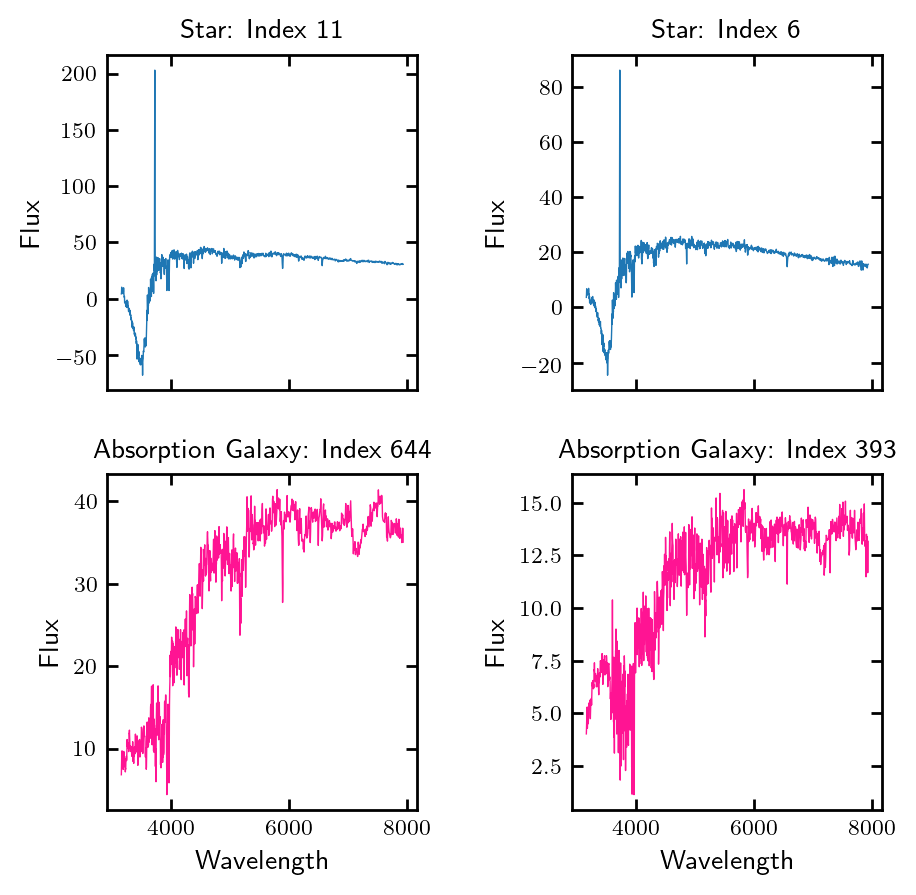

In [5]:
# Inspect
fig, axs = plt.subplots(2,2, facecolor='w', edgecolor='k', dpi = 200,figsize = [5,5], sharex = True)
fig.subplots_adjust(hspace = 0.25, wspace=.5)

axs = axs.ravel()




for i in range(0,2):
    
    num = np.random.randint(0,len(flux_stars))
    axs[i].plot(wavelengths,flux_stars[np.random.randint(0,len(flux_stars))], linewidth = 0.5)
    axs[i].set_ylabel('Flux', fontsize = 10)
    axs[i].set_title('Star: Index '+ str(num) )
    



for i in range(2,4):
    num = np.random.randint(0,len(flux_gals))
    axs[i].plot(wavelengths,flux_gals[num], linewidth = 0.5, color = 'deeppink')
    axs[i].set_ylabel('Flux', fontsize = 10)
    axs[i].set_xlabel('Wavelength', fontsize = 10)
    axs[i].set_title('Absorption Galaxy: Index '+ str(num) )
    


In [6]:
# Normalize: Divide by integrated flux

# Stars
for i in range(0,len(flux_stars)):
    flux_stars[i] = flux_stars[i] / np.trapz(flux_stars[i],wavelengths)

# Galaxies
for i in range(0,len(flux_gals)):
    flux_gals[i] = flux_gals[i] / np.trapz(flux_gals[i], wavelengths)

print("Mean Flux from Stars:" + str(np.mean(flux_stars)))
print("Mean Flux from Galaxies:" + str(np.mean(flux_gals)))



Mean Flux from Stars:0.00017525903
Mean Flux from Galaxies:0.00019290464


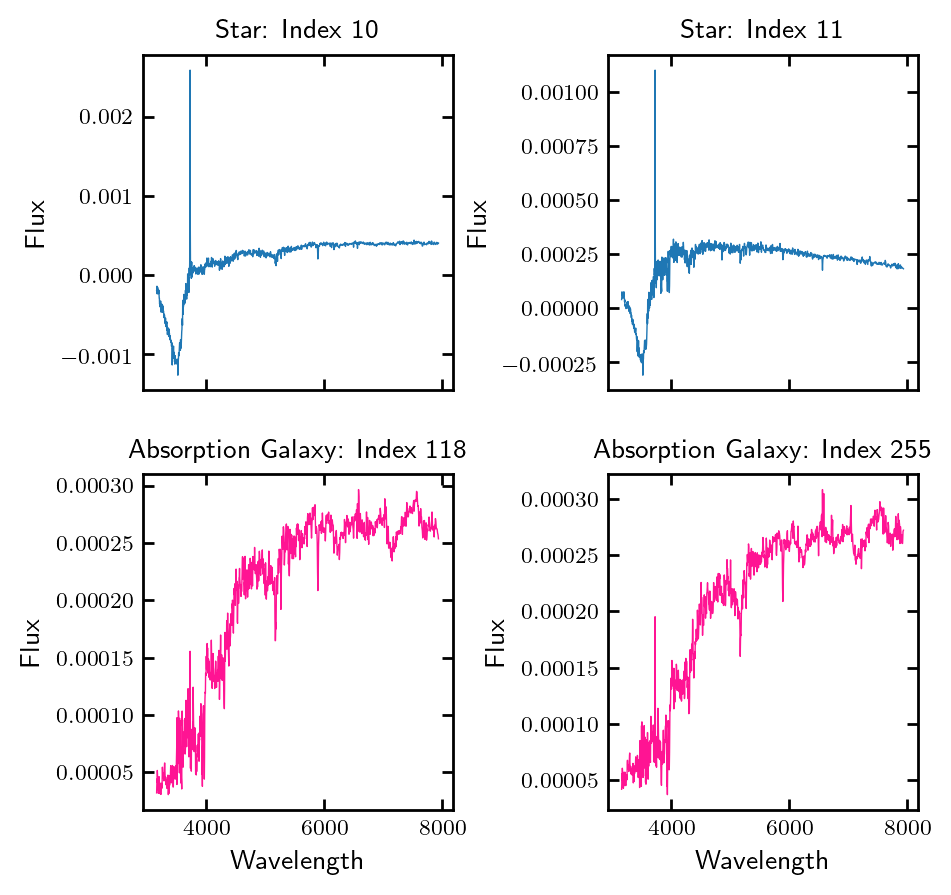

In [10]:

# Plot a few 

fig, axs = plt.subplots(2,2, facecolor='w', edgecolor='k', dpi = 200,figsize = [5,5], sharex = True)
fig.subplots_adjust(hspace = 0.25, wspace=.5)

axs = axs.ravel()




for i in range(0,2):
    
    num = np.random.randint(0,len(flux_stars))
    axs[i].plot(wavelengths,flux_stars[np.random.randint(0,len(flux_stars))], linewidth = 0.5)
    axs[i].set_ylabel('Flux', fontsize = 10)
    axs[i].set_title('Star: Index '+ str(num) )
    



for i in range(2,4):
    num = np.random.randint(0,len(flux_gals))
    axs[i].plot(wavelengths,flux_gals[num], linewidth = 0.5, color = 'deeppink')
    axs[i].set_ylabel('Flux', fontsize = 10)
    axs[i].set_xlabel('Wavelength', fontsize = 10)
    axs[i].set_title('Absorption Galaxy: Index '+ str(num) )
    



#plt.subplot(221, sharex = True)
#plt.loglog(wavelengths, flux_stars[np.random.randint(0,len(flux_stars))])



Next we'll need to compute the weighted mean so we can subtract it off of our data. We'll follow the prescription from lecture:

In [11]:
# Function from lecture
def GetWeightedMean(data,weights):
    meanout=np.zeros(data.shape[1])
    clustsize=data.shape[0]
    for i in range(0,data.shape[1]):
        datatemp=data[0:clustsize,i]
        weightstemp=weights[0:clustsize,i]
        meanout[i]=(np.sum(datatemp*weightstemp))/(np.sum(weightstemp))
    return meanout

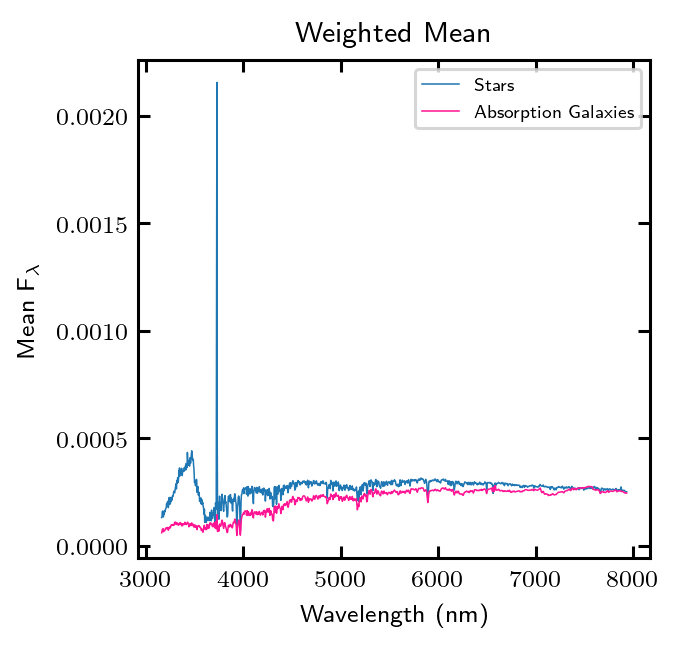

In [12]:
# Compute weighted mean; plot

weighted_mean_s=GetWeightedMean(flux_stars,weights_stars)
weighted_mean_g = GetWeightedMean(flux_gals,weights_gals)

plt.plot(wavelengths,weighted_mean_s, label = 'Stars', linewidth = 0.5)
plt.plot(wavelengths,weighted_mean_g, color = 'deeppink', label = 'Absorption Galaxies', linewidth = 0.5)


plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean F$_\lambda$')
plt.title("Weighted Mean")

plt.legend(fontsize = 6)

In [13]:
# Function for weighted means:
def SubtractWeightedMean(data,mean):
    clustsize=data.shape[0]
    meansize=mean.shape[0]
    dataout=np.zeros([clustsize,meansize])
    for i in range(0,clustsize):
        dataout[i,0:meansize]=data[i,0:meansize]-mean[0:meansize]
    return dataout

#For stars
data_sub_s=SubtractWeightedMean(flux_stars,weighted_mean_s)
# And galaxies
data_sub_g=SubtractWeightedMean(flux_gals,weighted_mean_g)

Let's inspect a few of the results

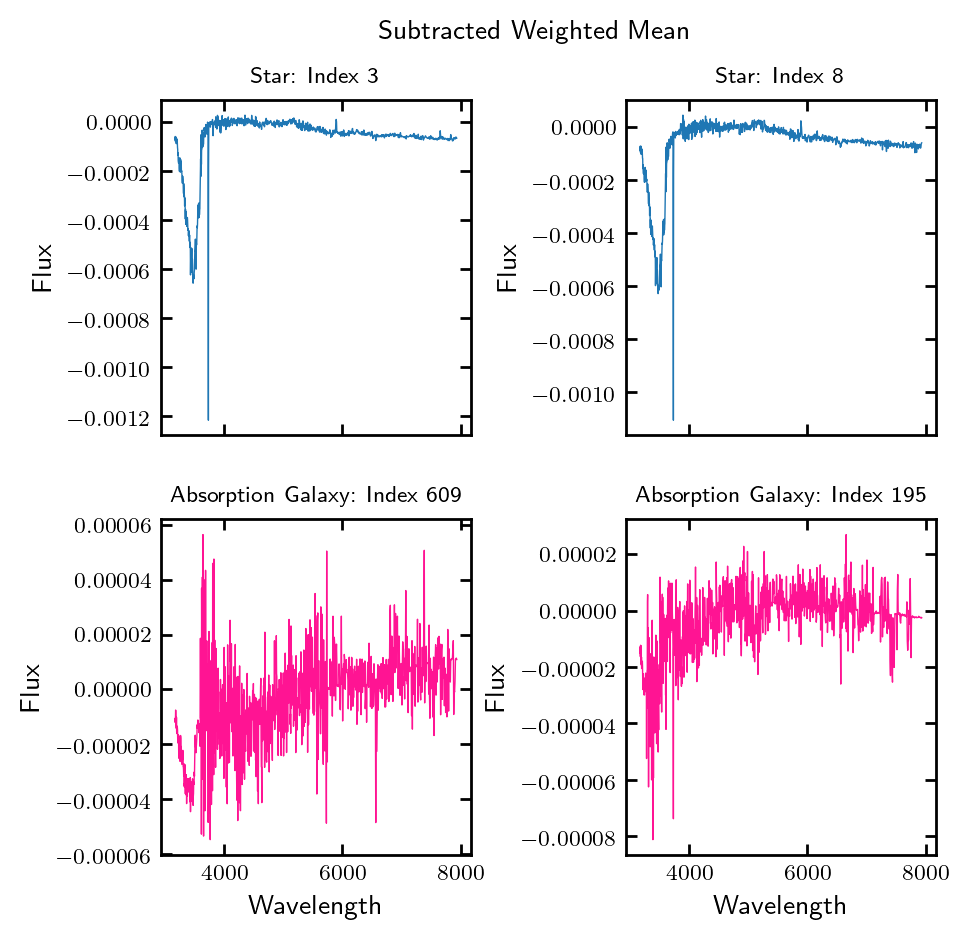

In [14]:
# Plot the above curves

fig, axs = plt.subplots(2,2, facecolor='w', edgecolor='k', dpi = 200,figsize = [5,5], sharex = True)
fig.subplots_adjust(hspace = 0.25, wspace=.5)

fig.suptitle("Subtracted Weighted Mean", x =0.5, y = 0.96)


axs = axs.ravel()

# Pull indices from above plot titles. This is hard coded out of laziness; you'll have to update 
# these number if you run this on your own!
indices = [3,8,609,195]


for i in range(0,2):
    axs[i].plot(wavelengths,data_sub_s[indices[i]], linewidth = 0.5, color = 'tab:blue')
    axs[i].set_ylabel('Flux', fontsize = 10)
    axs[i].set_title('Star: Index '+ str(indices[i]), fontsize = 8 )
    

for i in range(2,4):
    axs[i].plot(wavelengths,data_sub_g[indices[i]], linewidth = 0.5, color = 'deeppink')
    axs[i].set_ylabel('Flux', fontsize = 10)
    axs[i].set_xlabel('Wavelength', fontsize = 10)
    axs[i].set_title('Absorption Galaxy: Index '+ str(indices[i]), fontsize = 8 )
    

______________________________
### Part 2

Run `empca` on the result.  You'll notice that the reported reduced $\chi^2$ is low.  That is due to the estimated variances.

How many eigenvectors do you think you need to keep?  Plot the eigenvectors you need to keep.

$\textit{Answer:}$
Follow the cookbook from lecture.

In [15]:
# Read in empca
from empca import empca

# For stars 
m_s = empca(data_sub_s, weights = weights_stars, niter=25, nvec=25, smooth=0, randseed=1, silent=False)

fractional_s=np.zeros(25)
for i in range(0,25):
    fractional_s[i]=m_s.R2vec(i)

/home/idies/workspace/Storage/bbonine/persistent/lecture_16/empca.py:254: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = N.linalg.lstsq(A, b)[0]


       iter        R2             rchi2
EMPCA  1/25      -0.08610254     -0.00001433
EMPCA  2/25      -2.44378698     -0.00002344
EMPCA  3/25      -1.46102990     -0.00001914
EMPCA  4/25       0.39392844     -0.00000652
EMPCA  5/25       0.87282257     -0.00000093
EMPCA  6/25       0.95539705     -0.00000022
EMPCA  7/25       0.94298171     -0.00000044
EMPCA  8/25       0.95796565     -0.00000032
EMPCA  9/25       0.96067756     -0.00000030
EMPCA 10/25       0.96576538     -0.00000022
EMPCA 11/25       0.96939555     -0.00000020
EMPCA 12/25       0.96442440     -0.00000028
EMPCA 13/25       0.95537009     -0.00000040
EMPCA 14/25       0.90805172     -0.00000072
EMPCA 15/25       0.79403888     -0.00000137
EMPCA 16/25       0.71201856     -0.00000195
EMPCA 17/25       0.88541511     -0.00000081
EMPCA 18/25       0.87549763     -0.00000040
EMPCA 19/25       0.21035366     -0.00000209
EMPCA 20/25     -10.39695400     -0.00006415
EMPCA 21/25      -1.70406780     -0.00001287
EMPCA 22/25    

To get an idea of the number of Eigenvectors we can take a look at the fractional varience explained:

[-9.43105009e-02  2.69806746e-01  6.98181969e-02  3.65404500e-03
  6.17241143e-03  1.63572441e-02  4.39939729e-02  1.62564424e-02
  4.42503442e-03  3.58359724e-03  1.01121425e-03  1.45157208e-03
  1.99780497e-03  5.02187895e-04  6.26386463e-04  6.73065443e-04
  5.22385270e-04  3.00618888e-04  3.81384577e-04  2.46708885e-04
  2.83911097e-04  2.71784155e-04  3.19826788e-04  1.92406383e-04
  5.45984233e-05]


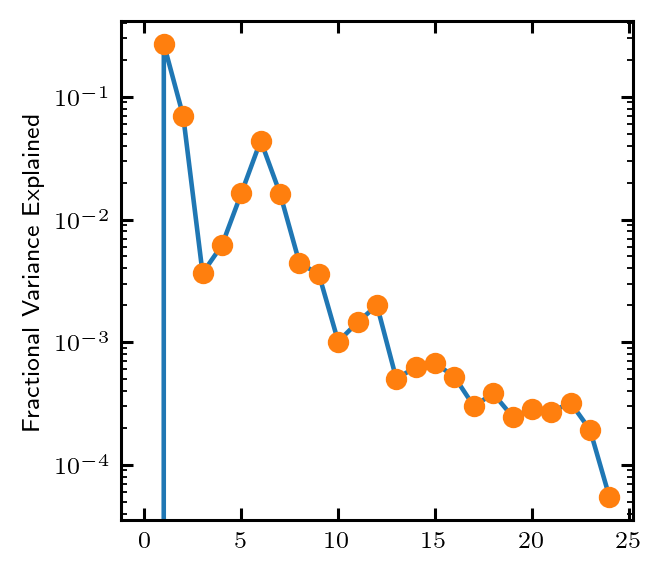

In [16]:
plt.semilogy(fractional_s)
plt.semilogy(fractional_s,'o', linewidth = 1)
plt.ylabel('Fractional Variance Explained')
print(fractional_s)

Let's repeat this analysis but the absorption galaxy sample:

In [17]:
# For galaxies 
m_g = empca(data_sub_g, weights = weights_gals, niter=25, nvec=25, smooth=0, randseed=1, silent=False)

fractional_g=np.zeros(25)
for i in range(0,25):
    fractional_g[i]=m_g.R2vec(i)

/home/idies/workspace/Storage/bbonine/persistent/lecture_16/empca.py:254: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = N.linalg.lstsq(A, b)[0]


       iter        R2             rchi2
EMPCA  1/25       0.02925973      0.00000005
EMPCA  2/25       0.69015623      0.00000002
EMPCA  3/25       0.79282852      0.00000001
EMPCA  4/25       0.80453411      0.00000001
EMPCA  5/25       0.81303208      0.00000001
EMPCA  6/25       0.81807047      0.00000001
EMPCA  7/25       0.81942645      0.00000001
EMPCA  8/25       0.82014919      0.00000001
EMPCA  9/25       0.82061157      0.00000001
EMPCA 10/25       0.82081648      0.00000001
EMPCA 11/25       0.82089128      0.00000001
EMPCA 12/25       0.82092512      0.00000001
EMPCA 13/25       0.82095454      0.00000001
EMPCA 14/25       0.82098985      0.00000001
EMPCA 15/25       0.82103265      0.00000001
EMPCA 16/25       0.82108285      0.00000001
EMPCA 17/25       0.82113938      0.00000001
EMPCA 18/25       0.82119962      0.00000001
EMPCA 19/25       0.82125993      0.00000001
EMPCA 20/25       0.82131677      0.00000001
EMPCA 21/25       0.82136784      0.00000001
EMPCA 22/25    

[ 5.42486665e-01  1.12289683e-01  4.34089698e-02  7.30463652e-03
 -1.24584686e-03  5.93026074e-03  2.50970084e-04  2.27027942e-03
  4.28160107e-03  4.23852887e-03  1.68727241e-03  1.81443889e-03
  1.30663664e-03  1.09727636e-03  7.96567988e-04  1.06122331e-03
  8.93807782e-04  1.00448304e-03  7.65378293e-04  7.71341850e-04
  6.91904110e-04  7.32706036e-04  6.41276591e-04  7.96205355e-04
  5.92443220e-04]


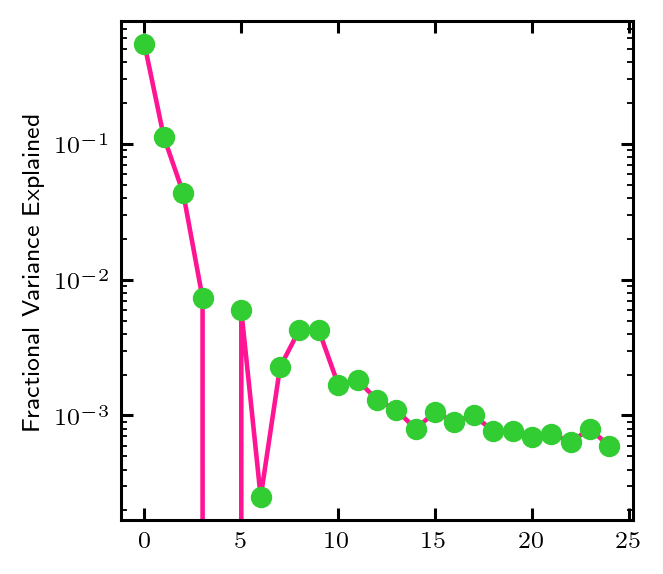

In [18]:
plt.semilogy(fractional_g, color = 'deeppink')
plt.semilogy(fractional_g,'o', linewidth = 1, color = 'limegreen')
plt.ylabel('Fractional Variance Explained')
print(fractional_g)

It looks like maybe 5 or 6 Eigenvectors is ideal to characterize our data. Let's try plotting the Eigenvectors:

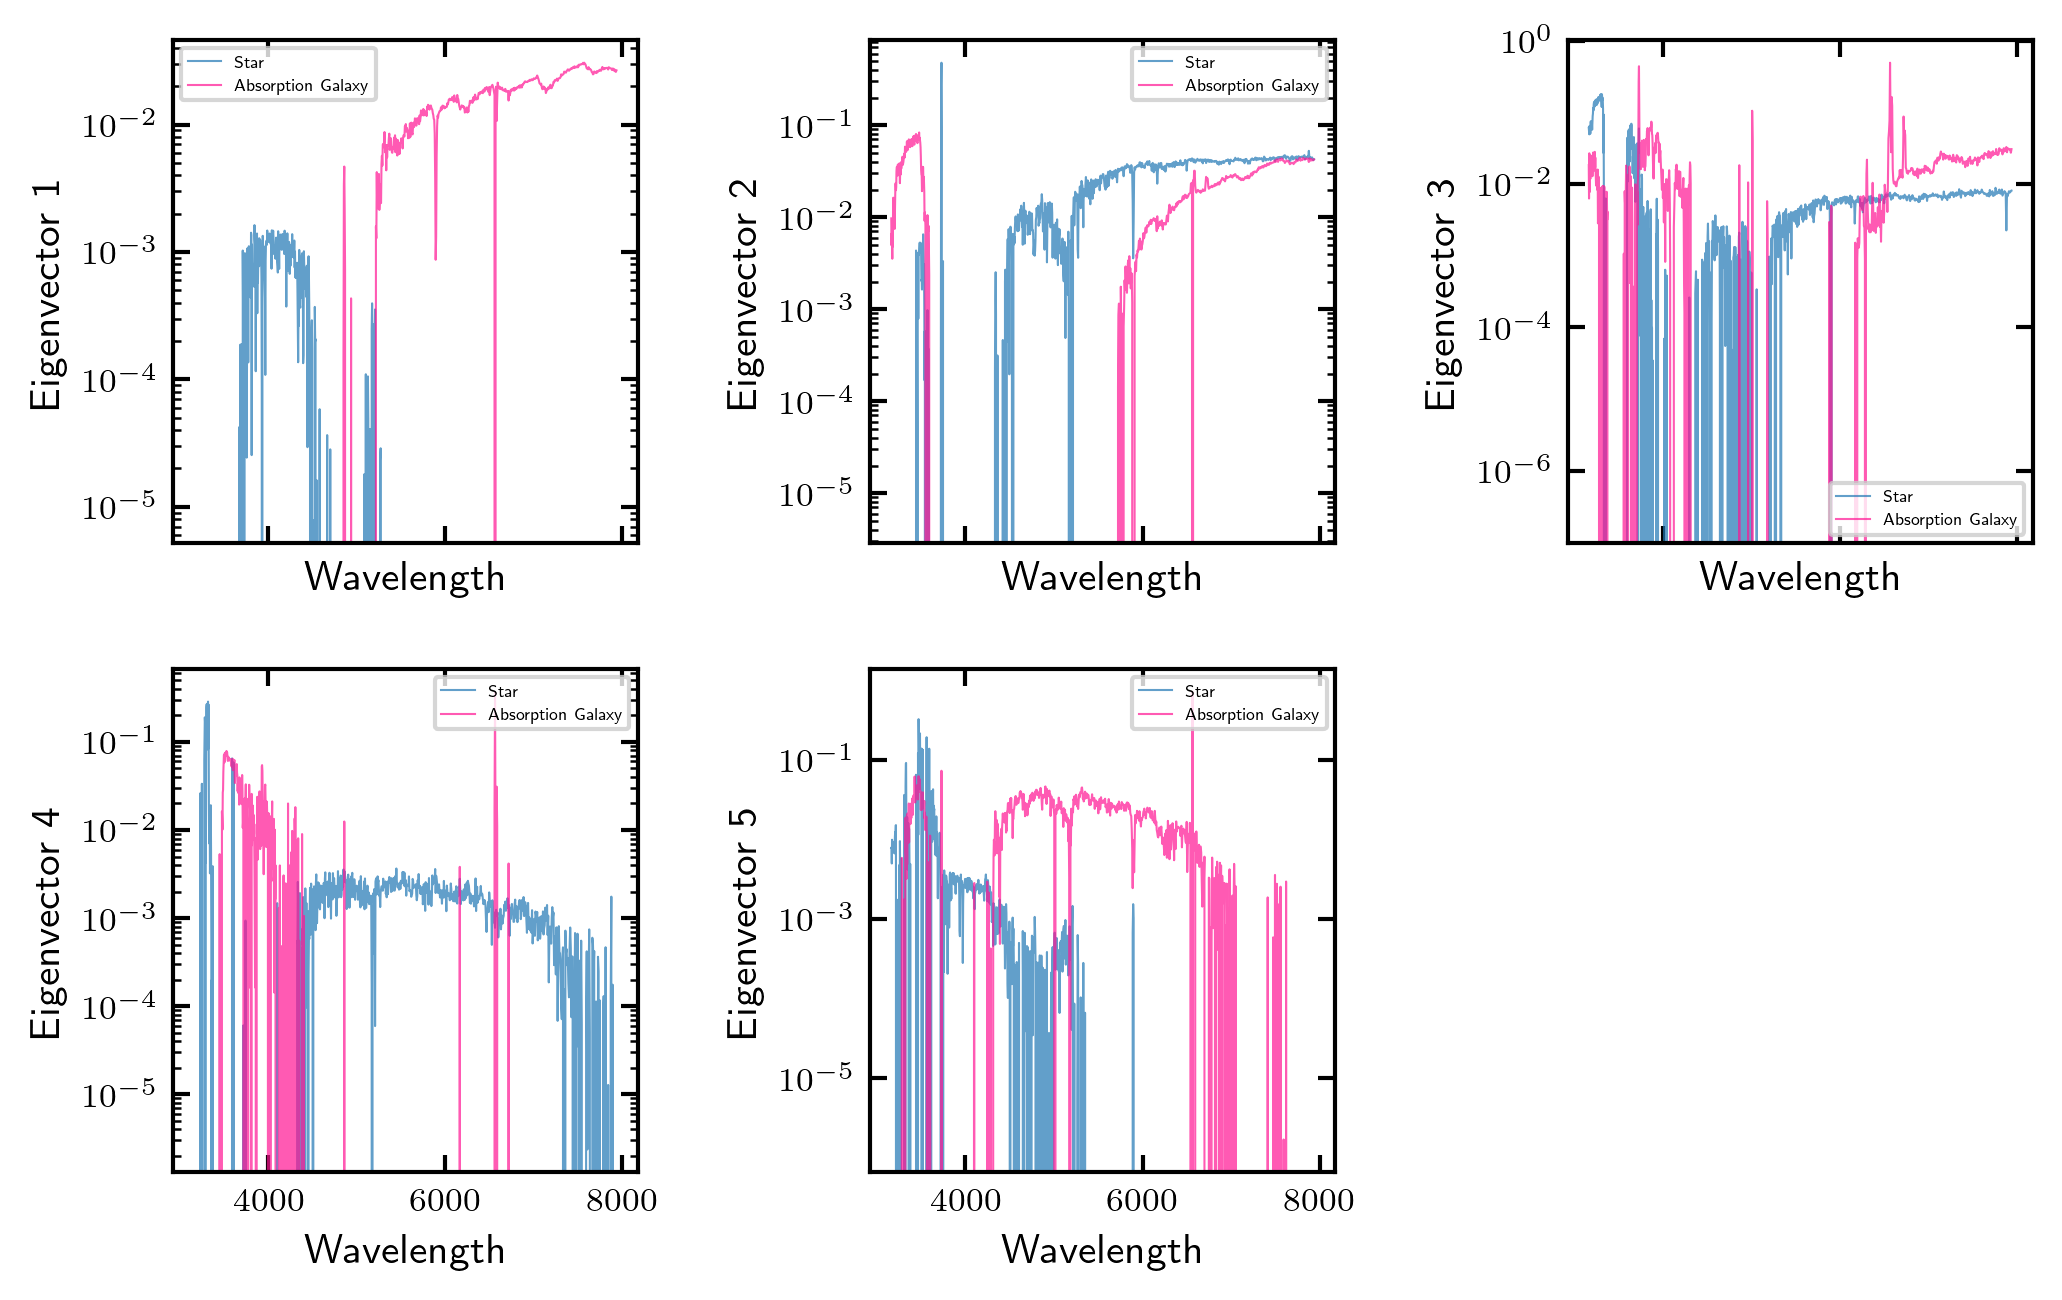

In [19]:
# Plot
fig, axs = plt.subplots(2,3, facecolor='w', edgecolor='k', dpi = 300,figsize = [8,5], sharex = True)
fig.subplots_adjust(hspace = 0.25, wspace=.5)




axs = axs.ravel()

for i in range(0,5):
    axs[i].semilogy(wavelengths,-m_s.eigvec[i], alpha = 0.7, linewidth = 0.5, label = 'Star')
    axs[i].semilogy(wavelengths,-m_g.eigvec[i], color = 'deeppink', alpha = 0.7, linewidth = 0.5, label = 'Absorption Galaxy')
    axs[i].set_ylabel('Eigenvector ' +str(i+1), fontsize = 10)
    axs[i].set_xlabel('Wavelength', fontsize = 10)
    axs[i].legend(fontsize = 4)

# Delete empty subplot    
fig.delaxes(axs[5])


__________________________

### Part 3

Pick one of your spectra, and check the reconstruction using the eigenvectors.  How good is it?  




### $\textit{Answer:}$
We'll choose two of the spectra sampled above:

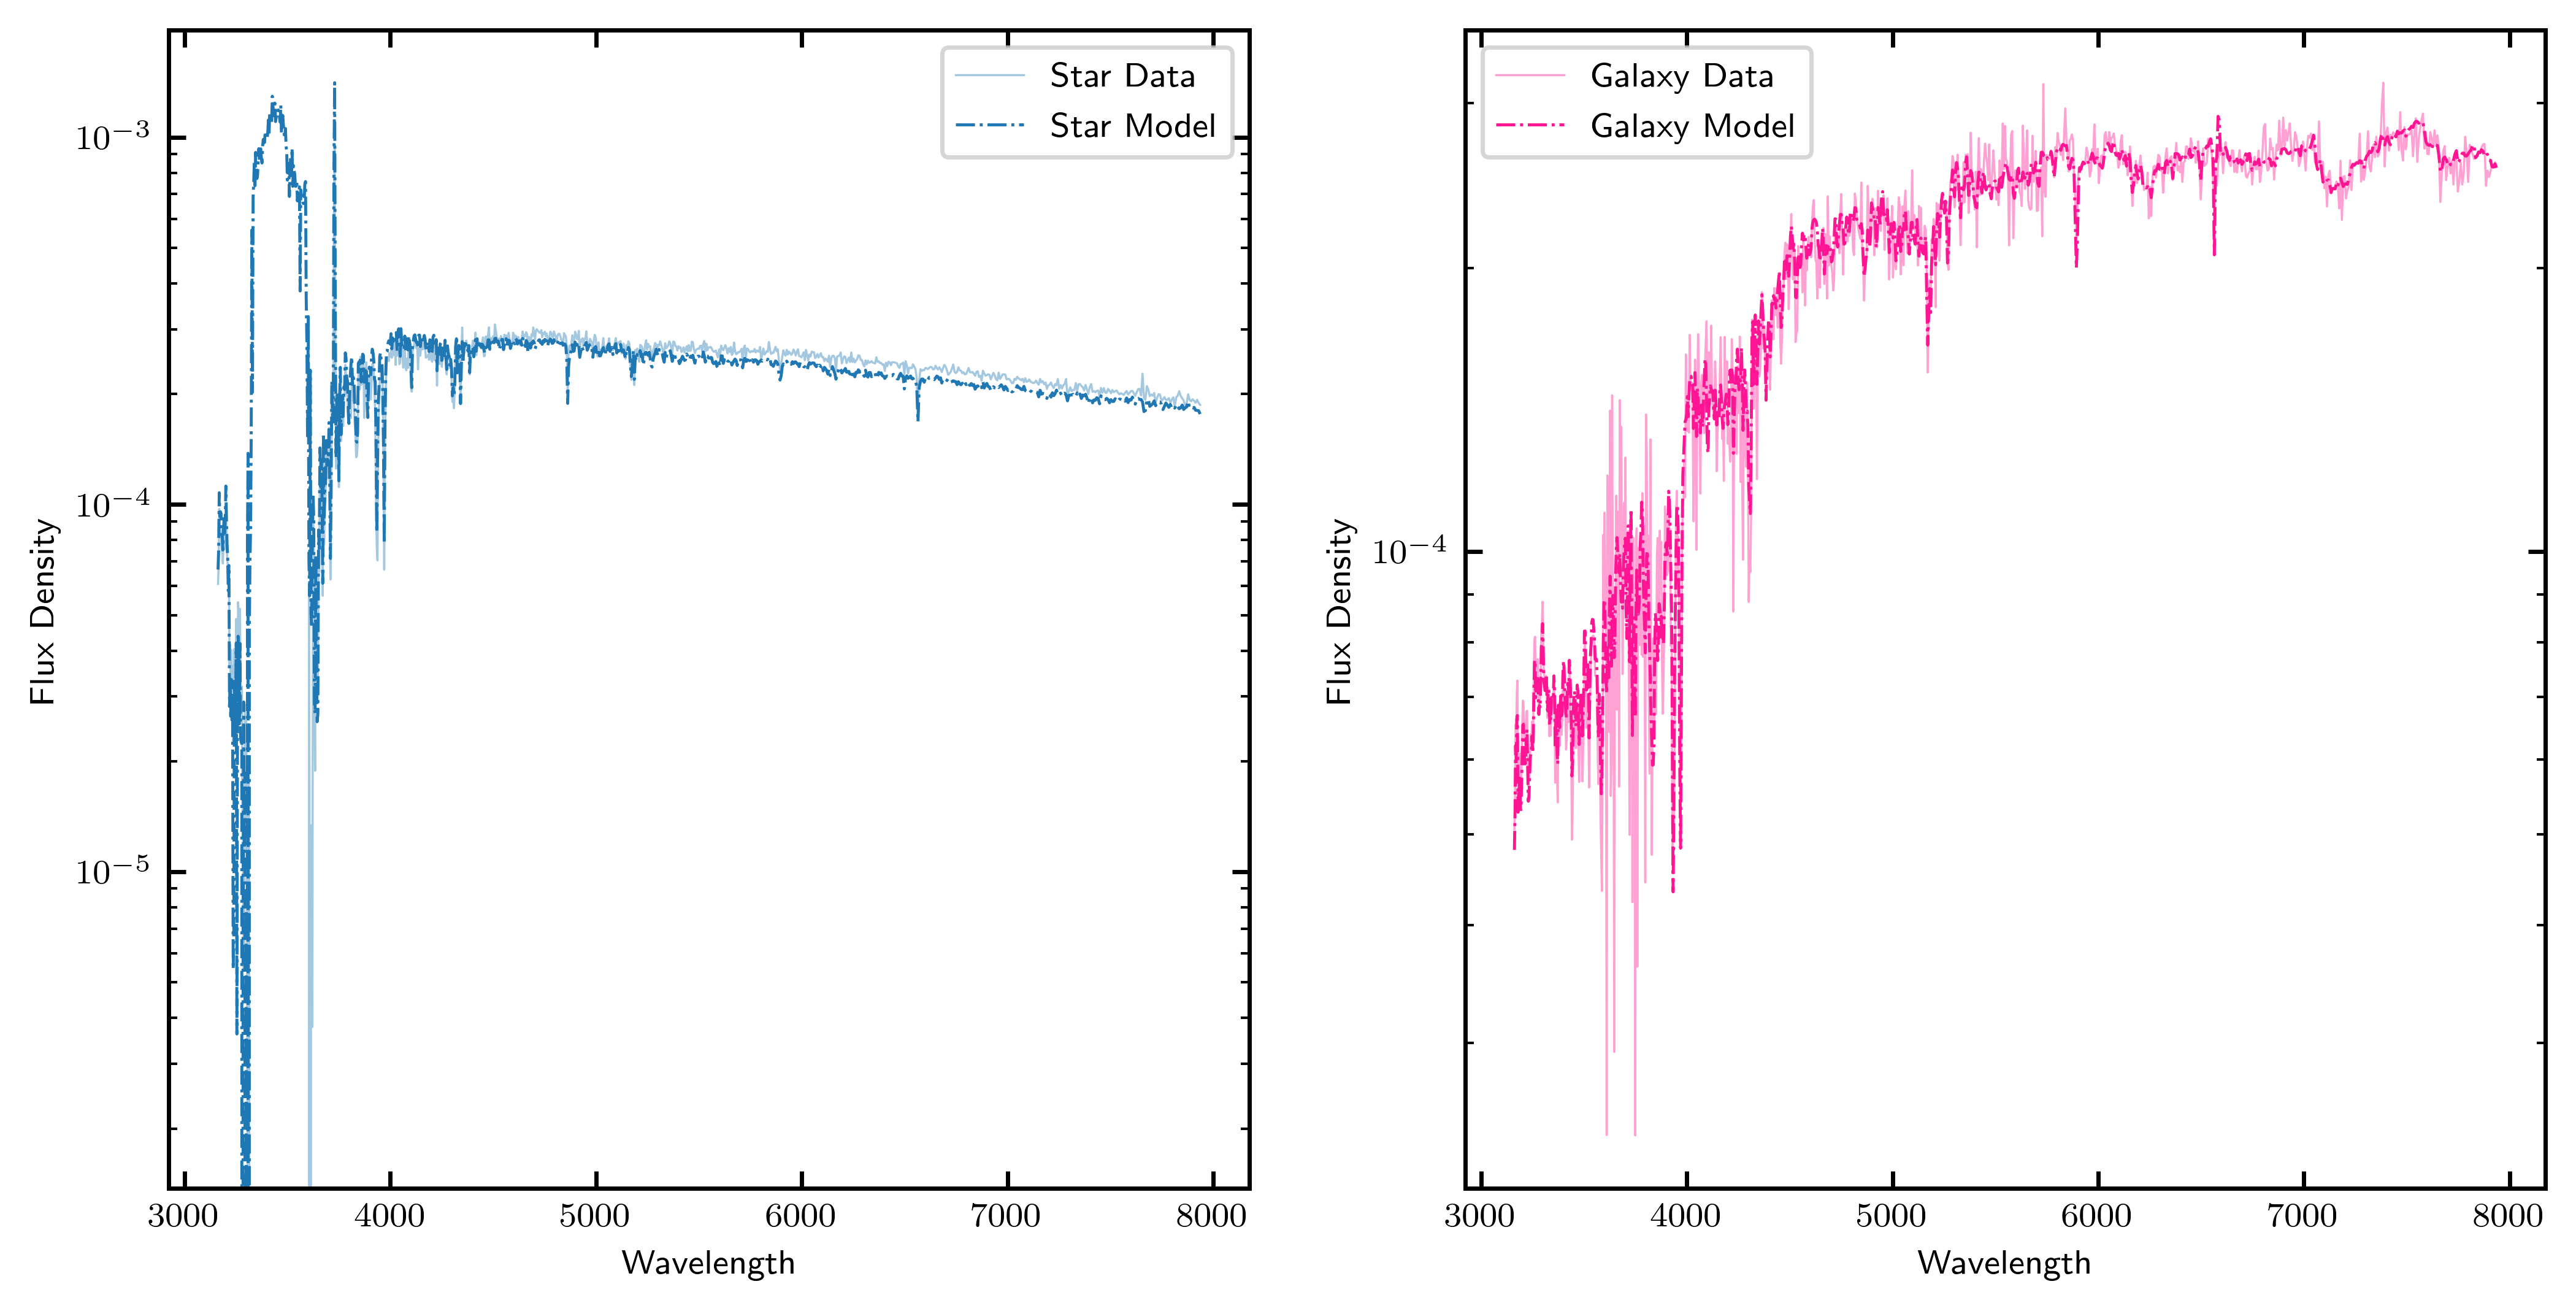

In [20]:
index_star = 3
index_gal = 609

plt.figure(figsize = [10,5], dpi = 500)

'''
%%%%%%%%%%%%%%%%
Star
%%%%%%%%%%%%%%%%
'''
plt.subplot(121)

plt.semilogy(wavelengths,flux_stars[index_star], color = 'tab:blue', label = 'Star Data', linewidth = 0.5, alpha = 0.4)

model_s=weighted_mean_s+m_s.coeff[index_star,0]*m_s.eigvec[0]+m_s.coeff[index_star,1]*m_s.eigvec[1]+m_s.coeff[index_star,2]*m_s.eigvec[2]+m_s.coeff[index_star,3]*m_s.eigvec[3]+m_s.coeff[index_star,4]*m_s.eigvec[4]
plt.semilogy(wavelengths,model_s,color = 'tab:blue', linestyle = '-.', label = 'Star Model', linewidth = 0.7)
plt.legend(fontsize = 8)
plt.xlabel('Wavelength')
plt.ylabel('Flux Density')


'''
%%%%%%%%%%%%%%%%
Galaxy
%%%%%%%%%%%%%%%%
'''
plt.subplot(122)

plt.semilogy(wavelengths,flux_gals[index_gal], color = 'deeppink', label = 'Galaxy Data', linewidth = 0.5, alpha = 0.4)

model_g=weighted_mean_g+m_g.coeff[index_gal,0]*m_g.eigvec[0]+m_g.coeff[index_gal,1]*m_g.eigvec[1]+m_g.coeff[index_gal,2]*m_g.eigvec[2]+m_g.coeff[index_gal,3]*m_g.eigvec[3]+m_g.coeff[index_gal,4]*m_g.eigvec[4]
plt.semilogy(wavelengths,model_g,color = 'deeppink', linestyle = '-.', label = 'Galaxy Model', linewidth = 0.7)

plt.xlabel('Wavelength')
plt.ylabel('Flux Density')
plt.legend(fontsize = 8)

So it looks like our Eigenvectors very accurately approximate the data at the long wavelength regieme but run into some difficulties for small lambda.

### Part 4 

Plot the eigenvector coeffients.  Using the known identifications, plot the "stars" using a different color than the "galaxies".  Do the stars fall in a different region of parameter space than the galaxies?

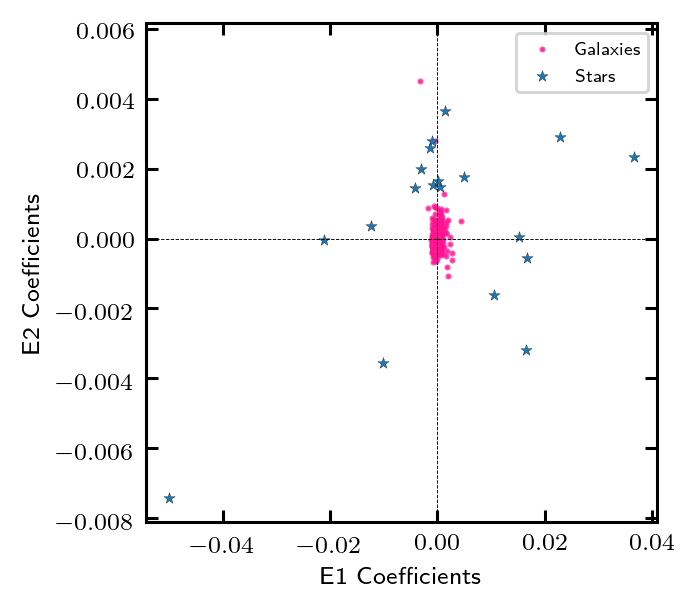

In [21]:
# Inspect Coefficients

# Show origin
plt.axhline(0.0,color='black',linestyle='dashed', linewidth = 0.3)
plt.axvline(0.0,color='black',linestyle='dashed', linewidth = 0.3)

plt.scatter(m_g.coeff[:,0],m_g.coeff[:,1], label = 'Galaxies', color = 'deeppink', s = 1, alpha = 0.7)
plt.scatter(m_s.coeff[:,0],m_s.coeff[:,1], label = 'Stars', s = 15, marker = '*', linewidth = 0.1, edgecolor = 'black')


plt.ylabel('E2 Coefficients')
plt.xlabel('E1 Coefficients')
plt.legend(fontsize = 6)


The distribution for both the galaxy and star eigenvector coefficients look to be scattered around (0,0) as expeced. 

An obvious difference between the two is that the galaxy eigenvector coefficients are scattered much more tighly around the origin than the star coefficients. Both distributions looks to be scewed toward slightly higher values of E2.

Text(0, 0.5, 'Coefficient')

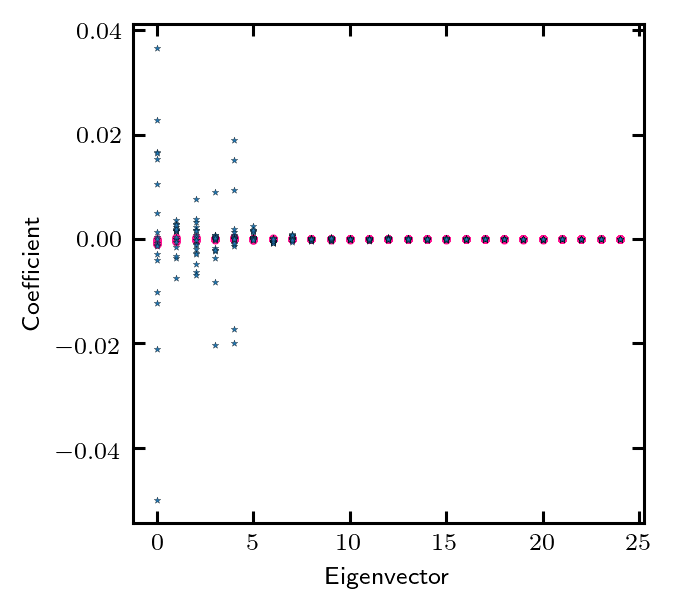

In [22]:
for i in range(0,25):
    plt.scatter(np.arange(0,25),m_g.coeff[i,:], color = 'deeppink', s = 3, alpha = 0.7)

for i in range(0,19):
    plt.scatter(np.arange(0,25),m_s.coeff[i,:], color = 'tab:blue',s = 5, marker = '*', linewidth = 0.1, edgecolor = 'black')
    
    
plt.xlabel('Eigenvector') 
plt.ylabel('Coefficient')


A plot showing the distribution of coefficients for the first 25 Eigenvectors. Note that the star Eigenvector coefficinets are most strongly scattered for the first five eigenvectors before approaching a value near zero for additional eigenvectors. Although harder to see since the magnitude of the coeffficients is smaller, this appears to be the same for the galaxy sample.

This leads me to believe we really only need five or so eigenvectors to model the data since the contribution from additional eigenvectors will probably be small. 